In [1]:
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.pandas as ps
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, count, lit, min, max, mean, stddev
from pyspark.sql.functions import monotonically_increasing_id

from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LinearSVC

from ucimlrepo import fetch_ucirepo 
import warnings
warnings.filterwarnings("ignore")  # Ignore warnings coming from Arrow optimizations.
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"


/Users/start/opt/anaconda3/envs/spark/lib/python3.9/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


## **1.Data Undestanding**

#### 1.1 Dataset Overview

In [12]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 

# Remove duplicate rows
combined = pd.concat([X, y], axis=1).drop_duplicates()

# Check for identical X with different y and remove them
inconsistent_indices = combined[combined.duplicated(subset=combined.columns[:-1], keep=False) & combined.duplicated(subset=[combined.columns[-1]], keep=False)].index
if not inconsistent_indices.empty:
    combined = combined.drop(inconsistent_indices)

# Separate features and target after cleaning
X = combined.iloc[:, :-1]
y = pd.DataFrame(combined.iloc[:, -1], columns=['Diabetes_binary'])

In [20]:
# metadata 
# print(cdc_diabetes_health_indicators.metadata) 
  
# variable information 
# print(cdc_diabetes_health_indicators.variables) 


In [13]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("CDC Diabetes Health Indicators") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
# Converting a pandas DataFrame to a PySpark DataFrame
# X is the feature, y is the target variable
X_pyspark = spark.createDataFrame(X)
y_pyspark = spark.createDataFrame(y)

# Showing the Architecture of a PySpark DataFrame
X_pyspark.printSchema()
y_pyspark.printSchema()

root
 |-- HighBP: long (nullable = true)
 |-- HighChol: long (nullable = true)
 |-- CholCheck: long (nullable = true)
 |-- BMI: long (nullable = true)
 |-- Smoker: long (nullable = true)
 |-- Stroke: long (nullable = true)
 |-- HeartDiseaseorAttack: long (nullable = true)
 |-- PhysActivity: long (nullable = true)
 |-- Fruits: long (nullable = true)
 |-- Veggies: long (nullable = true)
 |-- HvyAlcoholConsump: long (nullable = true)
 |-- AnyHealthcare: long (nullable = true)
 |-- NoDocbcCost: long (nullable = true)
 |-- GenHlth: long (nullable = true)
 |-- MentHlth: long (nullable = true)
 |-- PhysHlth: long (nullable = true)
 |-- DiffWalk: long (nullable = true)
 |-- Sex: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Education: long (nullable = true)
 |-- Income: long (nullable = true)

root
 |-- Diabetes_binary: long (nullable = true)



In [14]:
ps_x = X_pyspark.pandas_api()
ps_y = y_pyspark.pandas_api()

In [15]:
ps_x.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000,226342.000000
mean,0.452280,0.439799,0.958921,28.695456,0.466997,0.045418,0.104104,0.730010,0.610196,0.792328,0.061562,0.945264,0.094198,2.605994,3.558045,4.743645,0.188136,0.436512,8.067619,4.972241,5.869551
std,0.497719,0.496364,0.198474,6.822059,0.498911,0.208220,0.305395,0.443955,0.487707,0.405642,0.240358,0.227464,0.292105,1.068907,7.759826,9.094868,0.390821,0.495954,3.101819,0.994195,2.096410
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,4.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,6.000000
75%,1.000000,1.000000,1.000000,32.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,4.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [16]:
ps_y.describe()

,Diabetes_binary
count,226342.000000
mean,0.148143
std,0.355243
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


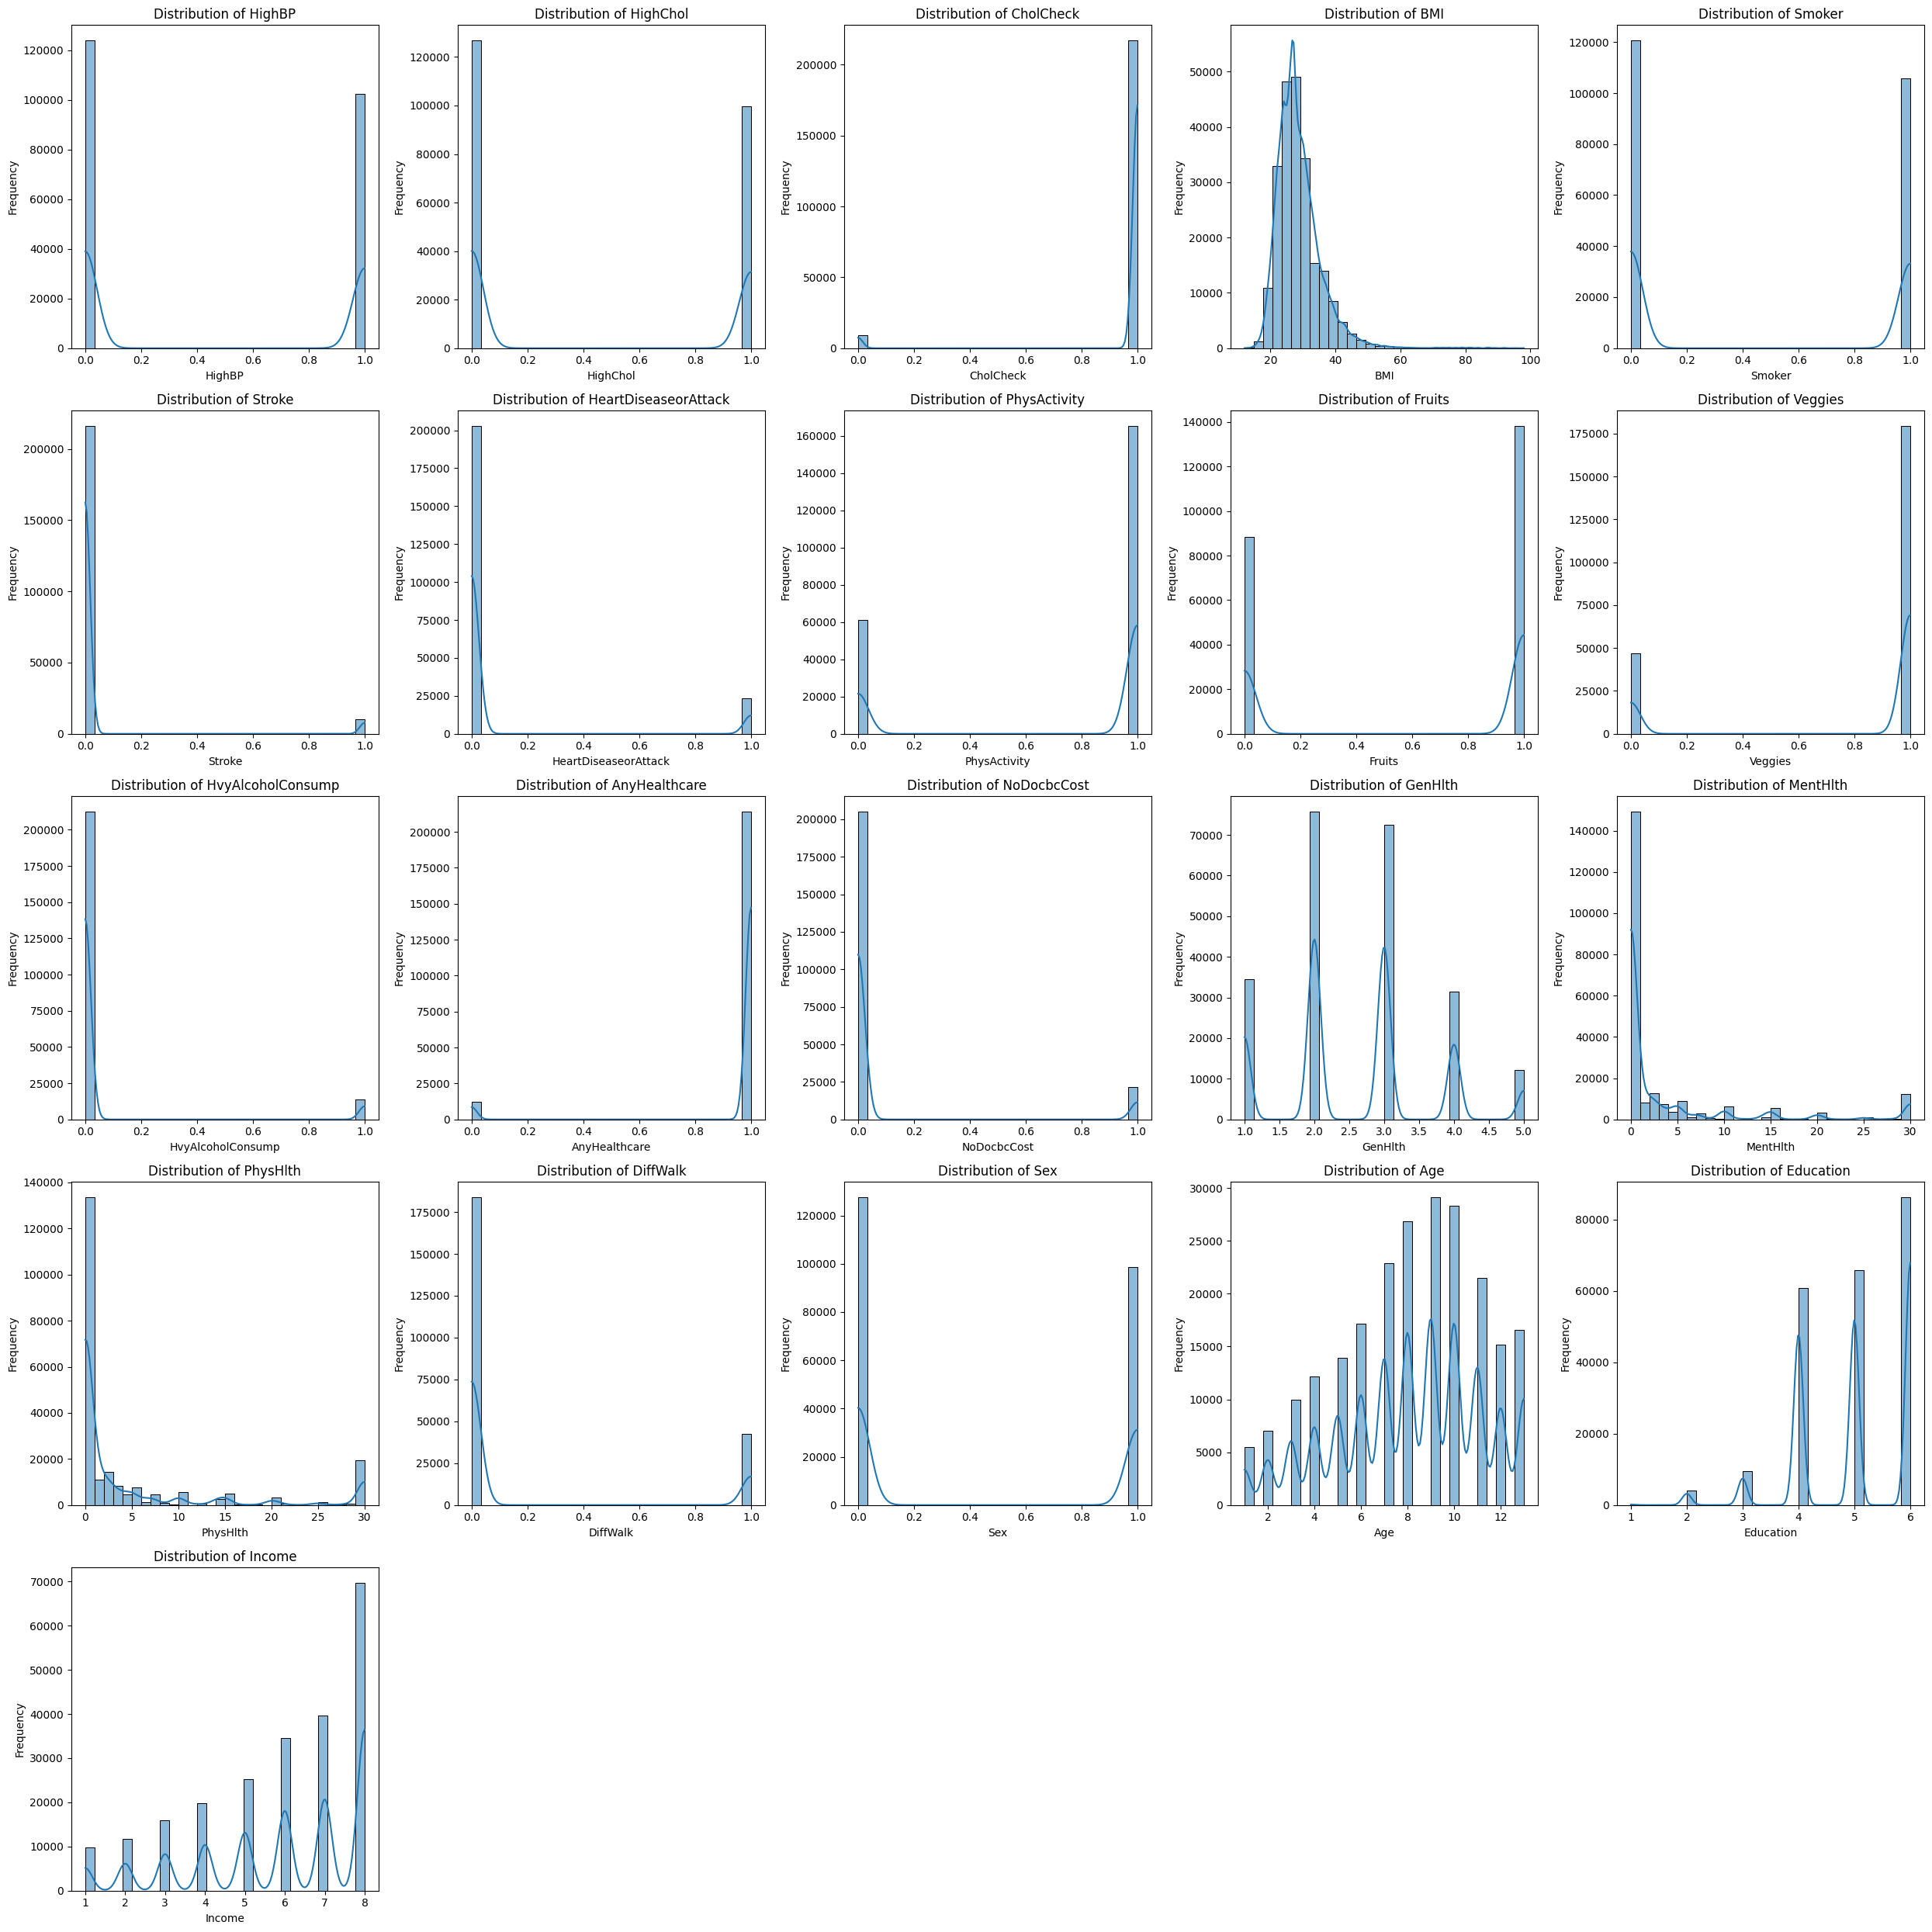

In [17]:
# Get the number of columns
num_columns = len(X_pyspark.columns)
num_rows = (num_columns // 5) + (1 if num_columns % 5 != 0 else 0)

# Create a 5x5 subgraph layout
fig, axes = plt.subplots(num_rows, 5, figsize=(25, 5 * num_rows))
axes = axes.flatten()

# Iterate through each column and compute the distribution data, which is then plotted in the subplot
for i, column in enumerate(X_pyspark.columns):
    # Use Spark to select the column and collect the data
    column_data = X_pyspark.select(column).rdd.flatMap(lambda x: x).collect()
    
    # Plotting histograms in the corresponding subplots
    sns.histplot(column_data, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove redundant subgraphs (if there are blank subgraphs)
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout to avoid overlapping subgraphs
plt.tight_layout()

## **2.Data Preprocessing**

#### 2.1 Validity Check

In [ ]:
# Define validity checks using a list of conditions
validity_checks = [
    ("HighBP", lambda c: (c == 0) | (c == 1)),
    ("HighChol", lambda c: (c == 0) | (c == 1)),
    ("CholCheck", lambda c: (c == 0) | (c == 1)),
    # ("BMI", lambda c: (c >= 10) & (c <= 80)),  # Example reasonable range
    ("Smoker", lambda c: (c == 0) | (c == 1)),
    ("Stroke", lambda c: (c == 0) | (c == 1)),
    ("HeartDiseaseorAttack", lambda c: (c == 0) | (c == 1)),
    ("PhysActivity", lambda c: (c == 0) | (c == 1)),
    ("Fruits", lambda c: (c == 0) | (c == 1)),
    ("Veggies", lambda c: (c == 0) | (c == 1)),
    ("HvyAlcoholConsump", lambda c: (c == 0) | (c == 1)),
    ("AnyHealthcare", lambda c: (c == 0) | (c == 1)),
    ("NoDocbcCost", lambda c: (c == 0) | (c == 1)),
    ("GenHlth", lambda c: (c >= 1) & (c <= 5)),
    ("MentHlth", lambda c: (c >= 0) & (c <= 30)),
    ("PhysHlth", lambda c: (c >= 0) & (c <= 30)),
    ("DiffWalk", lambda c: (c == 0) | (c == 1)),
    ("Sex", lambda c: (c == 0) | (c == 1)),
    ("Age", lambda c: (c >= 1) & (c <= 13)),
    ("Education", lambda c: (c >= 1) & (c <= 6)),
    ("Income", lambda c: (c >= 1) & (c <= 8))
]

for column_name, validity_check in validity_checks:
    # Filter rows that do not meet the validity check and count them
    invalid_count = X_pyspark.filter(~validity_check(col(column_name))).count()
    print(f"Feature '{column_name}' has {invalid_count} invalid entries.")


#### 2.2 Features Understanding(aggregation index)

In [9]:
# Summing Fruits and Veggies to indicate the healthiness of a diet
# Summing HighChol and HighBP to indicate overall cardiovascular risk
# Summing Smoker and HvyAlcoholConsump to indicate healthcare accessibility

X_pyspark = X_pyspark.withColumn('Diet', F.col('Fruits') + F.col('Veggies'))

X_pyspark = X_pyspark.withColumn('cardiovascular', F.col('HighChol')  + F.col('HighBP'))

X_pyspark = X_pyspark.withColumn('unhealthy_behavior', F.col('Smoker') + F.col('HvyAlcoholConsump'))

In [10]:
# 0：no healthcare and with cost problem。
# 1：no healthcare and no cost problem。
# 2：with healthcare but with cost problem。
# 3：with healthcare and no cost problem。

X_pyspark = X_pyspark.withColumn('healthcare',
    F.when((F.col('AnyHealthcare') == 1) & (F.col('NoDocbcCost') == 0), 3)
     .when((F.col('AnyHealthcare') == 1) & (F.col('NoDocbcCost') == 1), 2)
     .when((F.col('AnyHealthcare') == 0) & (F.col('NoDocbcCost') == 0), 1)
     .when((F.col('AnyHealthcare') == 0) & (F.col('NoDocbcCost') == 1), 0)
     .otherwise(-1))


#### 2.3 Data Transformation

In [11]:
# Min-Max Scaling: GenHlth, Age, Education, Income, BMI, MentHlth, PhysHlth, Diet, cardiovascular, unhealthy_behavior, healthcare
min_max_features = ["GenHlth", "Age", "Education", "Income", "BMI", "MentHlth", "PhysHlth", "Diet", "cardiovascular", "unhealthy_behavior", "healthcare"]

for feature in min_max_features:
    min_val = X_pyspark.agg(min(col(feature))).collect()[0][0]
    max_val = X_pyspark.agg(max(col(feature))).collect()[0][0]
    X_pyspark = X_pyspark.withColumn(
        feature,
        (col(feature) - min_val) / (max_val - min_val)
    )

# Standardization: BMI, MentHlth, PhysHlth
# standardize_features = ["BMI", "MentHlth", "PhysHlth"]

# for feature in standardize_features:
#     mean_val = X_pyspark.agg(mean(col(feature))).collect()[0][0]
#     stddev_val = X_pyspark.agg(stddev(col(feature))).collect()[0][0]
#     X_pyspark = X_pyspark.withColumn(
#         feature,
#         (col(feature) - mean_val) / stddev_val
#     )


In [ ]:
X_pyspark.show(5)

#### 2.4 Class Imbalance

In [ ]:
# Iterate through each column and compute the histogram data
for column in y_pyspark.columns:
    # Use the select and rdd methods of the Spark DataFrame to get the data for this column
    column_data = y_pyspark.select(column).rdd.flatMap(lambda x: x).collect()
    
    # Plot the histogram of the column
    plt.figure(figsize=(10, 5))
    sns.histplot(column_data, kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

## **3.Exploratory Data Analysis (EDA)**

#### 3.1 Descriptive Statistics

In [ ]:
# Convert back to pandas-on-Spark DataFrame
ps_x = X_pyspark.pandas_api()

ps_x.describe()

##### Plotting the distribution of all indicators

In [ ]:
# Get the number of columns
num_columns = len(X_pyspark.columns)
num_rows = (num_columns // 5) + (1 if num_columns % 5 != 0 else 0)

# Create a 5x5 subgraph layout
fig, axes = plt.subplots(num_rows, 5, figsize=(25, 5 * num_rows))
axes = axes.flatten()

# Iterate through each column and compute the distribution data, which is then plotted in the subplot
for i, column in enumerate(X_pyspark.columns):
    # Use Spark to select the column and collect the data
    column_data = X_pyspark.select(column).rdd.flatMap(lambda x: x).collect()
    
    # Plotting histograms in the corresponding subplots
    sns.histplot(column_data, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove redundant subgraphs (if there are blank subgraphs)
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout to avoid overlapping subgraphs
plt.tight_layout()

#### 3.2 Correlation Analysis

In [16]:
# Add a unique index column to both DataFrames to ensure row-wise splicing
X_with_id = X_pyspark.withColumn("id", monotonically_increasing_id())
y_with_id = y_pyspark.withColumn("id", monotonically_increasing_id())

# Splice features and targets together, matching by 'id' columns
joined_df = X_with_id.join(y_with_id, on='id', how='inner')

# Remove the 'id' column
joined_df = joined_df.drop('id')

In [ ]:
joined_df.show(5)

In [18]:
# Combine numerical features into a vector column using VectorAssembler
vector_col = "features"
assembler = VectorAssembler(inputCols=joined_df.columns, outputCol=vector_col)
df_vector = assembler.transform(joined_df).select(vector_col)

In [ ]:
# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, vector_col, "spearman").head()[0]

# Converting DenseMatrix to a NumPy array and then to a Python list
correlation_array = correlation_matrix.toArray().tolist()

# Creating an RDD and converting it to a Spark DataFrame
correlation_rdd = spark.sparkContext.parallelize(correlation_array)
correlation_df = correlation_rdd.toDF(joined_df.columns)

# Show correlation matrix
correlation_df.show(truncate=False)


In [ ]:
# Collecting data from a Spark DataFrame to a local list
correlation_data = correlation_df.collect()

# Converting Row Objects to 2D Lists
correlation_values = [list(row) for row in correlation_data]

# Heat mapping of correlations
plt.figure(figsize=(12, 10))
plt.imshow(correlation_values, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

# Setting the scale and labels for the x and y axes
plt.xticks(ticks=range(len(joined_df.columns)), labels=joined_df.columns, rotation=90)
plt.yticks(ticks=range(len(joined_df.columns)), labels=joined_df.columns)
plt.title('Correlation Heatmap for Numeric Features')

# Show Heat Map
plt.show()

In [ ]:
# Extract correlation data from Diabetes_binary column (last column)
diabetes_corr = [row['Diabetes_binary'] for row in correlation_data]

# Extracting other feature names as transverse labels
features = [col for col in joined_df.columns if col != 'Diabetes_binary']

# Plotting line graphs
plt.figure(figsize=(12, 6))
plt.plot(features, diabetes_corr[:-1], marker='o', linestyle='-', color='skyblue')  # Excluding the last item (Diabetes_binary's own correlation with itself)

# Setting up chart labels
plt.xlabel('Features')
plt.ylabel('Correlation with Diabetes_binary')
plt.title('Correlation of Features with Diabetes_binary')
plt.xticks(rotation=45, ha='right')  
plt.grid(True)

# Show Chart
plt.tight_layout()
plt.show()

#### 3.3 Bivariate Analysis

In [ ]:
# Extract the index of the Diabetes_binary column
diabetes_idx = correlation_df.columns.index('Diabetes_binary')

# Get feature names with Diabetes_binary correlation greater than 0.2
selected_columns = [
    correlation_df.columns[i] for i in range(len(correlation_df.columns))
    if correlation_data[i][diabetes_idx] > 0.2 and correlation_df.columns[i] != 'Diabetes_binary'
]

# Print correlation indicators greater than 0.2
print("Features with correlation greater than 0.2 with Diabetes_binary:")
print(selected_columns)

In [ ]:
# Selection of features and target variables of interest
selected_columns.append('Diabetes_binary')
selected_df = joined_df.select(selected_columns)

# Collecting data to the local environment
data = selected_df.collect()

# Converting collected data to Python lists
high_bp = [row['HighBP'] for row in data]
high_chol = [row['HighChol'] for row in data]
bmi = [row['BMI'] for row in data]
gen_hlth = [row['GenHlth'] for row in data]
diff_walk = [row['DiffWalk'] for row in data]
cardiovascular = [row['cardiovascular'] for row in data]
diabetes_binary = [row['Diabetes_binary'] for row in data]

# Plot histograms of each characteristic separately, grouped by whether they have diabetes or not
features = {
    'HighBP': high_bp,
    'HighChol': high_chol,
    'BMI': bmi,
    'GenHlth': gen_hlth,
    'DiffWalk': diff_walk,
    'cardiovascular': cardiovascular
}

plt.figure(figsize=(18, 18))

for idx, (feature_name, feature_data) in enumerate(features.items()):
    # Grouping of data by presence or absence of diabetes
    diabetic_data = [feature_data[i] for i in range(len(diabetes_binary)) if diabetes_binary[i] == 1]
    non_diabetic_data = [feature_data[i] for i in range(len(diabetes_binary)) if diabetes_binary[i] == 0]
    
    # Plotting histograms for each feature
    plt.subplot(2, 3, idx + 1)
    plt.hist(non_diabetic_data, bins=20, alpha=0.7, label='Non-diabetic', color='b')
    plt.hist(diabetic_data, bins=20, alpha=0.7, label='Diabetic', color='r')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    plt.title(f'{feature_name} Distribution in Healthy vs. Diabetic Population')
    plt.legend()

# Adjusting the layout and displaying the chart
plt.tight_layout()
plt.show()

#### 3.4 Chi-square Tests

In [ ]:
# Combine X and y into a single DataFrame
data_pyspark = X_pyspark.join(y_pyspark)

# Combine the features into a single vector column for ChiSquareTest
vector_assembler = VectorAssembler(inputCols=X_pyspark.columns, outputCol="features")
data_vector = vector_assembler.transform(data_pyspark)

# Run the Chi-square test on the features and the target variable
chi_square_result = ChiSquareTest.test(data_vector, "features", "Diabetes_binary")

# Show the results
chi_square_result.show(truncate=False)

In [ ]:
from sklearn.feature_selection import f_classif
# 将 PySpark DataFrame 转换为 Pandas DataFrame
data_pandas = data_pyspark.toPandas()
# 假设你的目标变量是 'Diabetes_binary'，其余的为特征
X = data_pandas.drop('Diabetes_binary', axis=1)  # 特征集
y = data_pandas['Diabetes_binary']  # 目标变量

# 计算 ANOVA F 值和 p 值
f_values, p_values = f_classif(X, y)

# 将结果与特征名称结合，方便查看
anova_results = pd.DataFrame({
    'Feature': X.columns,
    'F-value': f_values,
    'p-value': p_values
})



## **4.Feature Engineering and Dimensionality Reduction**

#### 4.1. Principal Components Analysis (PCA)

In [ ]:
assembler = VectorAssembler(inputCols=X_pyspark.columns, outputCol="features")
X_vector = assembler.transform(X_pyspark).select("features")

In [ ]:
pca = PCA(k=len(X_pyspark.columns), inputCol="features", outputCol="pca_features")
pca_model = pca.fit(X_vector)

# Transform the dataset with the PCA model
X_pca = pca_model.transform(X_vector)

In [ ]:
explained_variance = pca_model.explainedVariance.toArray()
print("Explained variance for each principal component:", explained_variance)

In [ ]:
explained_variance_list = pca_model.explainedVariance.tolist()

# Create a Spark DataFrame from the explained variance ratios
explained_variance_df = spark.createDataFrame(
    [(i + 1, explained_variance_list[i]) for i in range(len(explained_variance_list))],
    ["Component", "Explained Variance Ratio"]
)

# Calculate cumulative variance
explained_variance_df = explained_variance_df.withColumn(
    "Cumulative Variance", 
    F.sum("Explained Variance Ratio").over(Window.orderBy("Component"))
)

# Show the explained variance and cumulative variance
explained_variance_df.show(25)

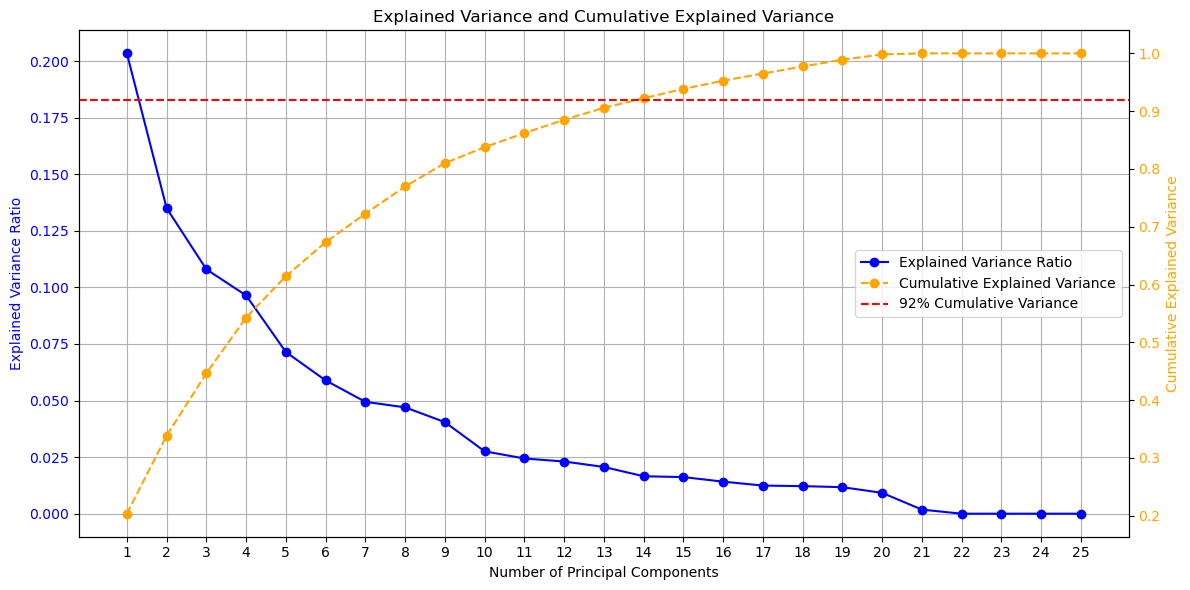

In [ ]:
# Convert to a Pandas DataFrame for plotting
explained_variance_pd = explained_variance_df.toPandas()

# Set up the figure and axes for two subplots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Scree plot (Explained Variance for each component)
line1, = ax1.plot(range(1, len(explained_variance) + 1), explained_variance, 
                  marker='o',  # Use dots as markers
                  linestyle='-',  # Line connecting the dots
                  color='b', 
                  label='Explained Variance Ratio')  # Add label for the legend
ax1.set_title('Explained Variance and Cumulative Explained Variance')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Explained Variance Ratio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()
# Create a second y-axis for cumulative variance
line2, = ax2.plot(explained_variance_pd["Component"], explained_variance_pd["Cumulative Variance"], 
                  marker='o', color='orange', linestyle='--', label='Cumulative Explained Variance')  # Add label for the legend
ax2.set_ylabel('Cumulative Explained Variance', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Adding a horizontal line at 92% cumulative variance for reference
line3 = ax2.axhline(y=0.92, color='red', linestyle='--', label='92% Cumulative Variance')

# Combine legends
handles = [line1, line2, line3]  # List of handles from both axes
labels = [line1.get_label(), line2.get_label(), '92% Cumulative Variance']  # Corresponding labels

# Create a single legend
ax1.legend(handles, labels, loc='center right')

# Show the plot
plt.xticks(range(1, len(explained_variance_pd) + 1))  # Set x-ticks to be the component numbers
plt.tight_layout()
plt.show()


##### 4.1.1. Selecting Number of Components Based on Explained Variance

In [ ]:
# Find the number of components that explain 92% of the variance
num_components_explained_variance = explained_variance_pd[explained_variance_pd["Cumulative Variance"] >= 0.92].index[0] + 1  # Add 1 because index starts at 0

# Print the number of components
print(f"Number of components explaining 92% of the variance: {num_components_explained_variance}")


Number of components explaining 92% of the variance: 14


In [ ]:
def plot_absolute_contributions(feature_loadings_df, num_components):
    selected_components = feature_loadings_df.iloc[:, :num_components]

    # Calculate the sum of the absolute values of contributions for each feature
    absolute_contributions = selected_components.abs().sum(axis=1)

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    absolute_contributions.plot(kind='bar', color='royalblue')
    plt.title(f'Sum of Absolute Contributions to First {num_components} Principal Components')
    plt.xlabel('Features')
    plt.ylabel('Sum of Absolute Contributions')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


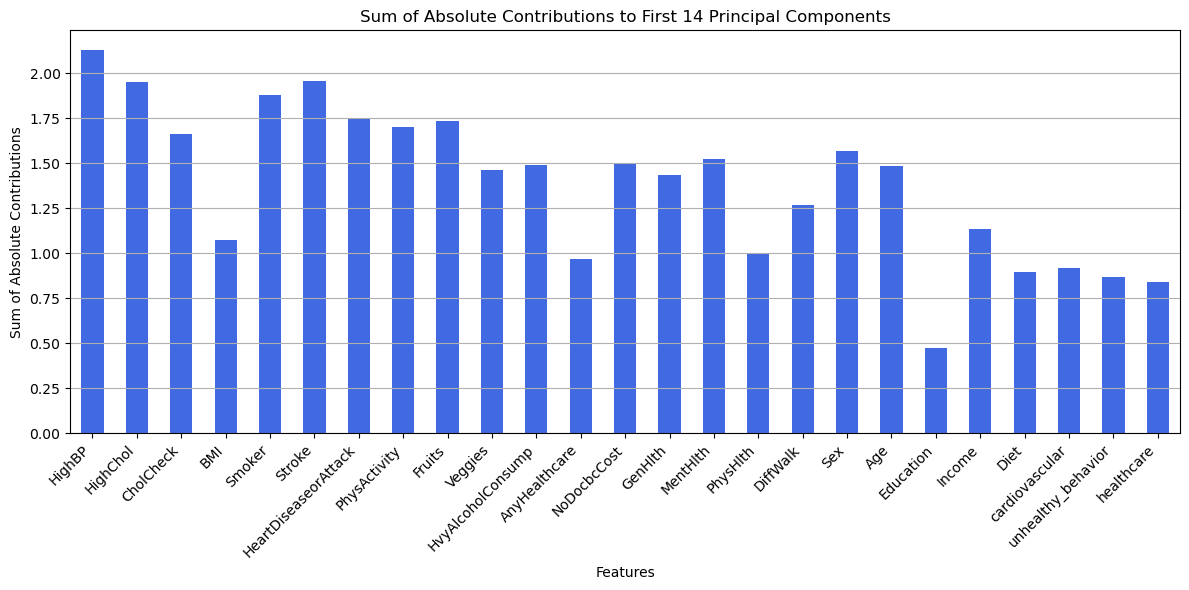

In [ ]:


# Assuming pca_model and X_pyspark are already defined
# Get the principal components (eigenvectors)
components = pca_model.pc.toArray()

# Create a Pandas-on-Spark DataFrame for feature loadings
feature_loadings_df_ps = ps.DataFrame(components, columns=X_pyspark.columns)

# Transpose the DataFrame for easier analysis
feature_loadings_df_ps = feature_loadings_df_ps.T
feature_loadings_df_ps.columns = [f'PC{i+1}' for i in range(feature_loadings_df_ps.shape[1])]

# Convert to a standard pandas DataFrame for easier manipulation
feature_loadings_df = feature_loadings_df_ps.to_pandas()

plot_absolute_contributions(feature_loadings_df, num_components_explained_variance)

##### 4.1.2. Selecting Number of Components Base on Elbow Method

In [ ]:
num_components_elbow_method = 10
print(f'Based on the elbow method and the plot of the Explained Variance, the number of components should be: {num_components_elbow_method}')

Based on the elbow method and the plot of the Explained Variance, the number of components should be: 10


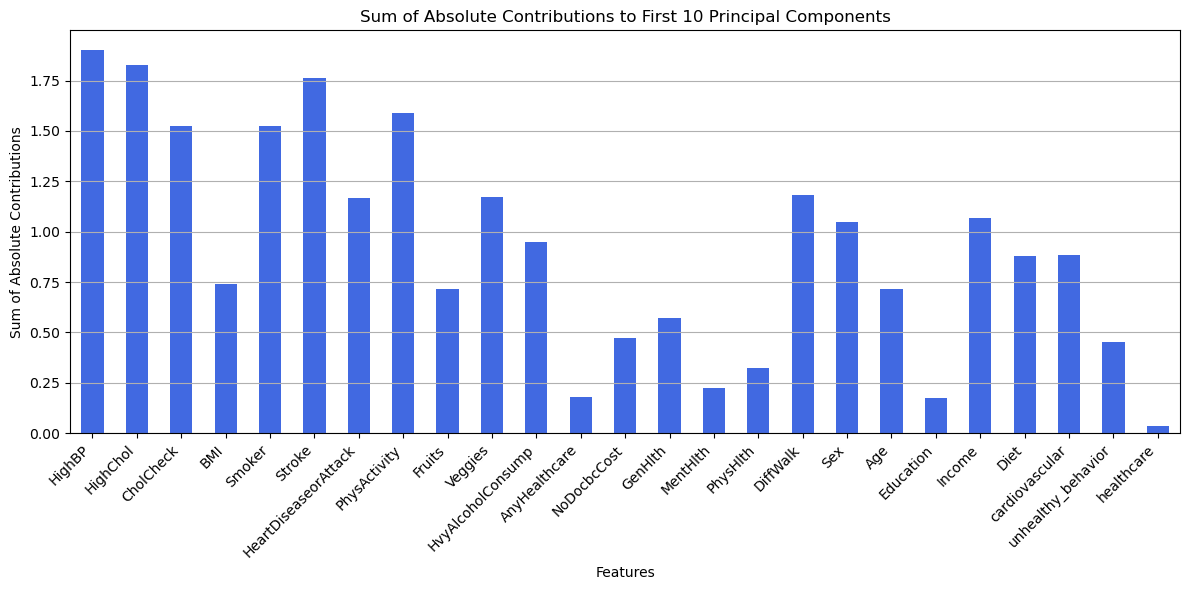

In [ ]:
plot_absolute_contributions(feature_loadings_df, num_components_elbow_method)

##### 4.1.3. Correlation between PCA Components and the Target

In [ ]:
pca_df = X_pca.select('pca_features')

# Define a function to extract the elements of the vector and create new columns
def extract_components(row):
    return [float(x) for x in row[0]]  # Extracting values from the vector

# Use rdd and map to convert the pca_features to separate columns
pca_components = pca_df.rdd.map(extract_components)

# Create a new DataFrame with the principal components
pca_X_pyspark = spark.createDataFrame(pca_components, schema=[f'PC{i+1}' for i in range(14)])

# Show the new DataFrame with principal components
pca_X_pyspark.show(truncate=False)

+--------------------+---------------------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+-------------------+--------------------+---------------------+---------------------+--------------------+-------------------+-------------------+---------------------+----------------------+--------------------+---------------------+--------------------+-------------------+---------------------+----------------------+----------------------+-------------------+
|PC1                 |PC2                  |PC3                  |PC4                 |PC5                 |PC6                 |PC7                  |PC8                  |PC9                |PC10                |PC11                 |PC12                 |PC13                |PC14               |_15                |_16                  |_17                   |_18                 |_19                  |_20                 |_21                |_22            

In [ ]:
# from pyspark.sql import functions as F


# # Step 1: Combine pca_X_pyspark and y_pyspark into one DataFrame
# combined_df = pca_X_pyspark.join(y_pyspark, how='inner')

# # Step 2: Extract feature names from pca_X_pyspark and the target variable
# pca_features = pca_X_pyspark.columns
# target_variable = y_pyspark.columns[0]  # Assuming y_pyspark has only one column

# # Step 3: Calculate the correlation of each PCA feature with the target variable
# correlations = {pca_feature: combined_df.stat.corr(pca_feature, target_variable) for pca_feature in pca_features}

# # Step 4: Convert the correlations dictionary to a DataFrame
# correlation_df = ps.DataFrame(list(correlations.items()), columns=['Principal Component', 'Correlation'])

# # Optionally round the values if needed
# correlation_df['Correlation'] = correlation_df['Correlation'].round(3)

# # Step 5: Display the correlation DataFrame
# print(correlation_df)


##### 4.1.4. Correlation between PCA Components and the Initial Features

In [ ]:
# Create a Pandas-on-Spark DataFrame for feature loadings
feature_contribution_df_ps = ps.DataFrame(components, columns=X_pyspark.columns)

# Transpose the DataFrame for easier analysis
feature_contribution_df_ps = feature_contribution_df_ps.T
feature_contribution_df_ps.columns = [f'PC{i+1}' for i in range(feature_contribution_df_ps.shape[1])]

# Convert to a standard pandas DataFrame for easier manipulation and display
feature_contribution_df_ps = feature_contribution_df_ps.to_pandas()

# Round the values to 3 decimal places
feature_contribution_df_ps = feature_contribution_df_ps.round(3)

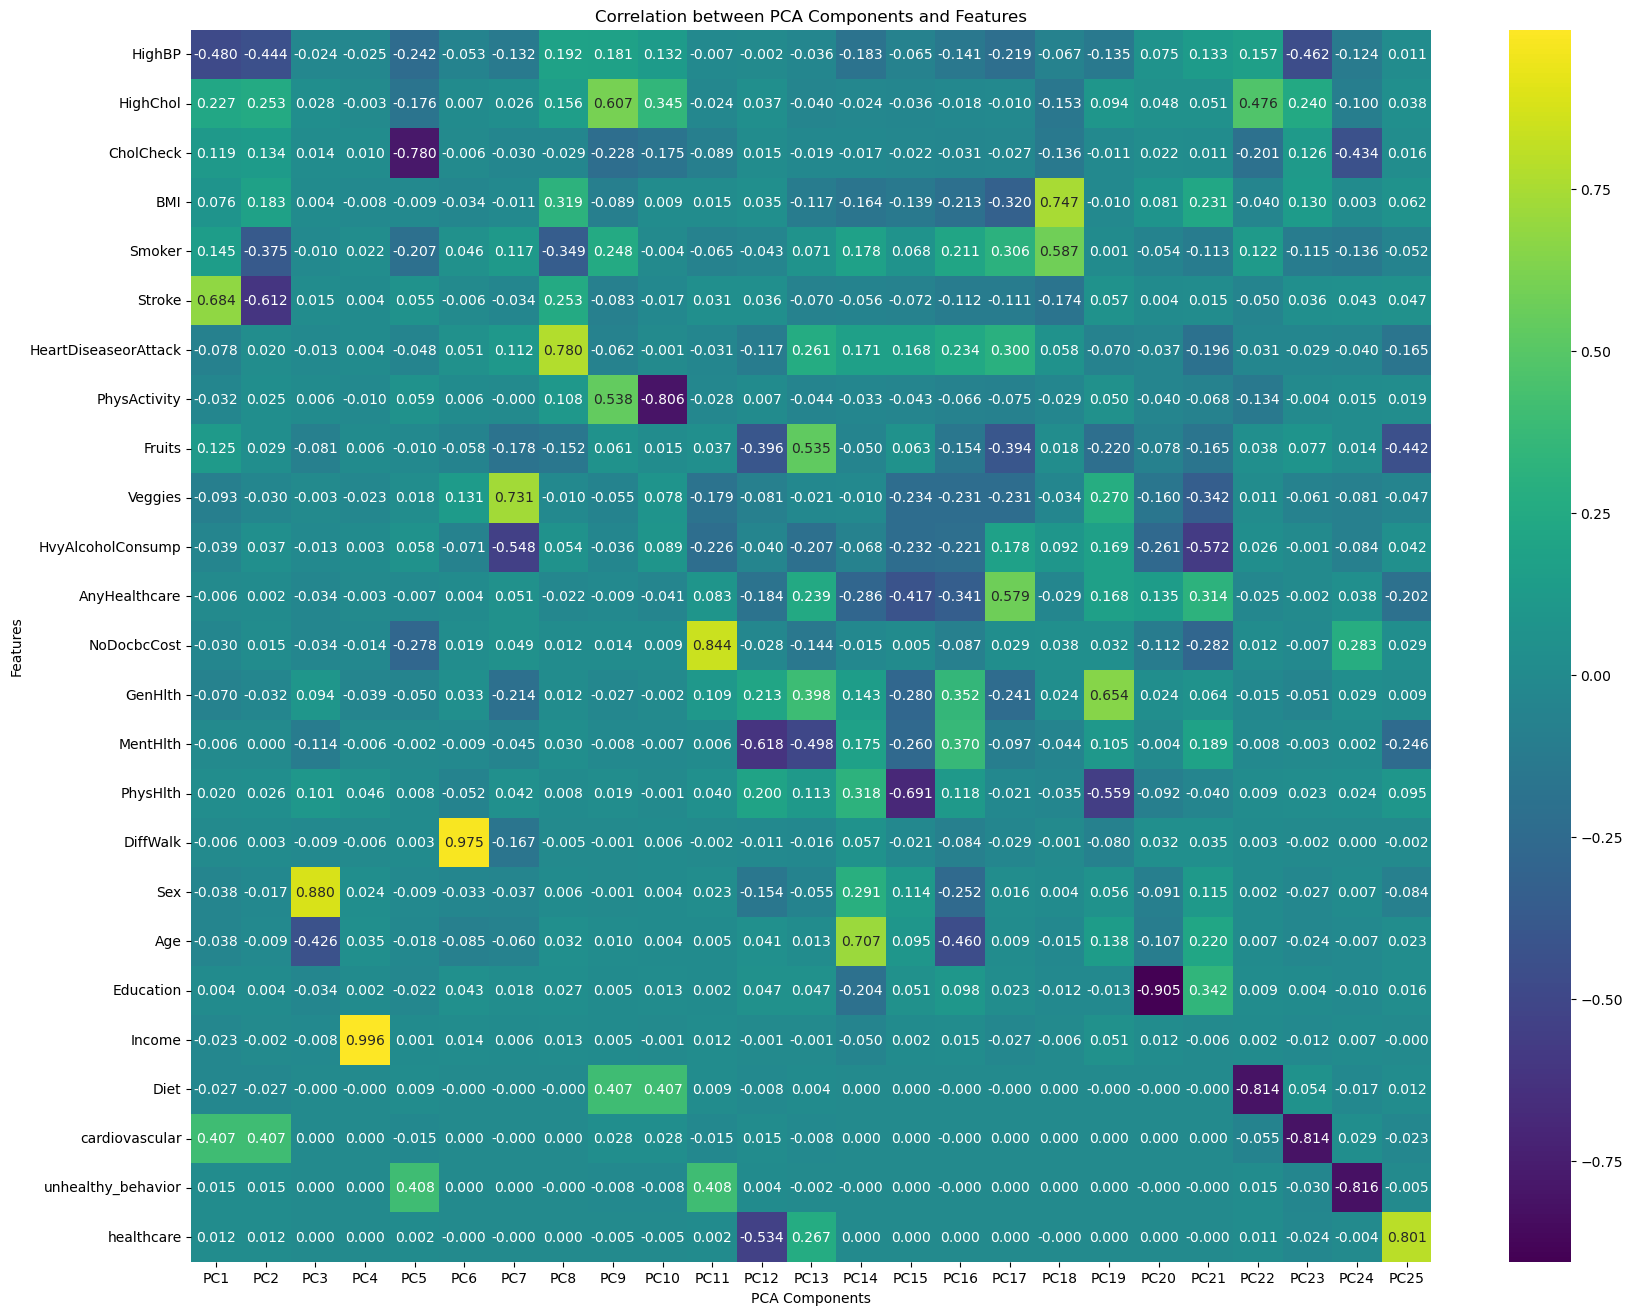

In [ ]:
# Assuming 'feature_loadings_df' is already created and rounded as per your earlier steps
# feature_loadings_df = feature_loadings_df.round(3)

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Create a heatmap with seaborn
sns.heatmap(feature_contribution_df_ps, annot=True, cmap='viridis', fmt='.3f', cbar=True)

# Add labels and title
plt.title("Correlation between PCA Components and Features")
plt.xlabel("PCA Components")
plt.ylabel("Features")

# Show the plot
plt.show()


##### 4.1.5. PCA with 2 Components

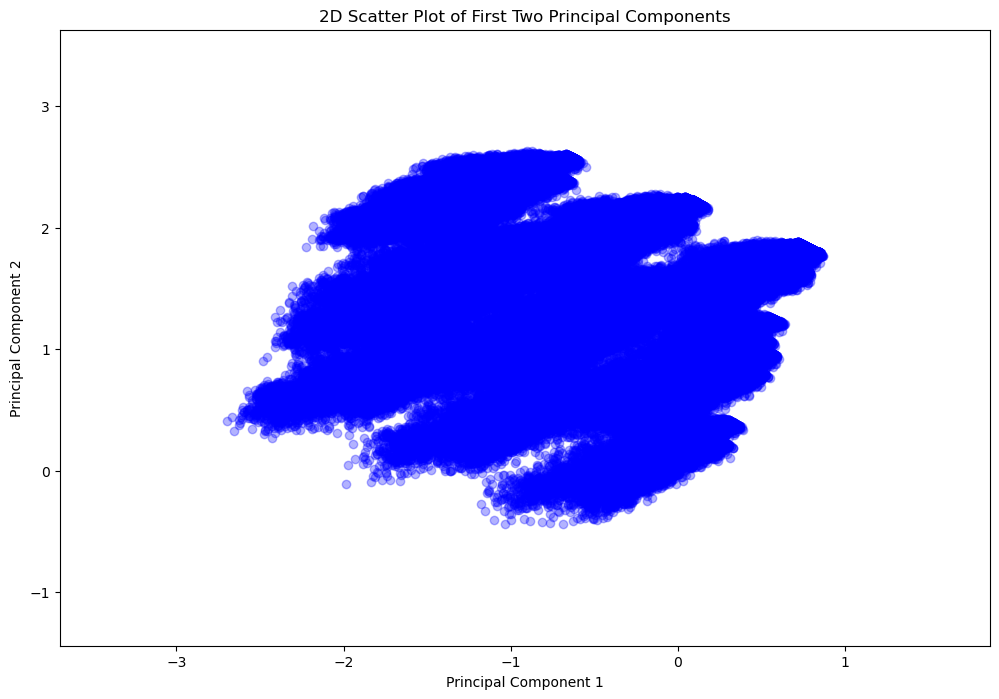

In [ ]:
# Step 1: Define and fit the PCA model
pca = PCA(k=2, inputCol="features", outputCol="pca_features")  # Using 2 components
pca_model = pca.fit(X_vector)

# Step 2: Transform the dataset with the PCA model
X_pca_new = pca_model.transform(X_vector)

# Step 3: Convert the transformed PCA features into a NumPy array
pca_features = np.array(X_pca_new.select("pca_features").rdd.map(lambda row: row[0].toArray()).collect())

# Step 4: Plot the first two principal components in a 2D scatter plot
fig = plt.figure(figsize=(12, 8))  # Adjust the size based on your preference
ax = fig.add_subplot(111)

# Scatter plot of the first two principal components
ax.scatter(pca_features[:, 0], pca_features[:, 1], c='b', marker='o', alpha=0.3)

# Set the limits for the axes using Python's built-in min and max functions
ax.set_xlim(np.min(pca_features[:, 0]) - 1, np.max(pca_features[:, 0]) + 1)
ax.set_ylim(np.min(pca_features[:, 1]) - 1, np.max(pca_features[:, 1]) + 1)

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2D Scatter Plot of First Two Principal Components')

# Show the plot
plt.show()

##### 4.1.6. PCA with 3 Components

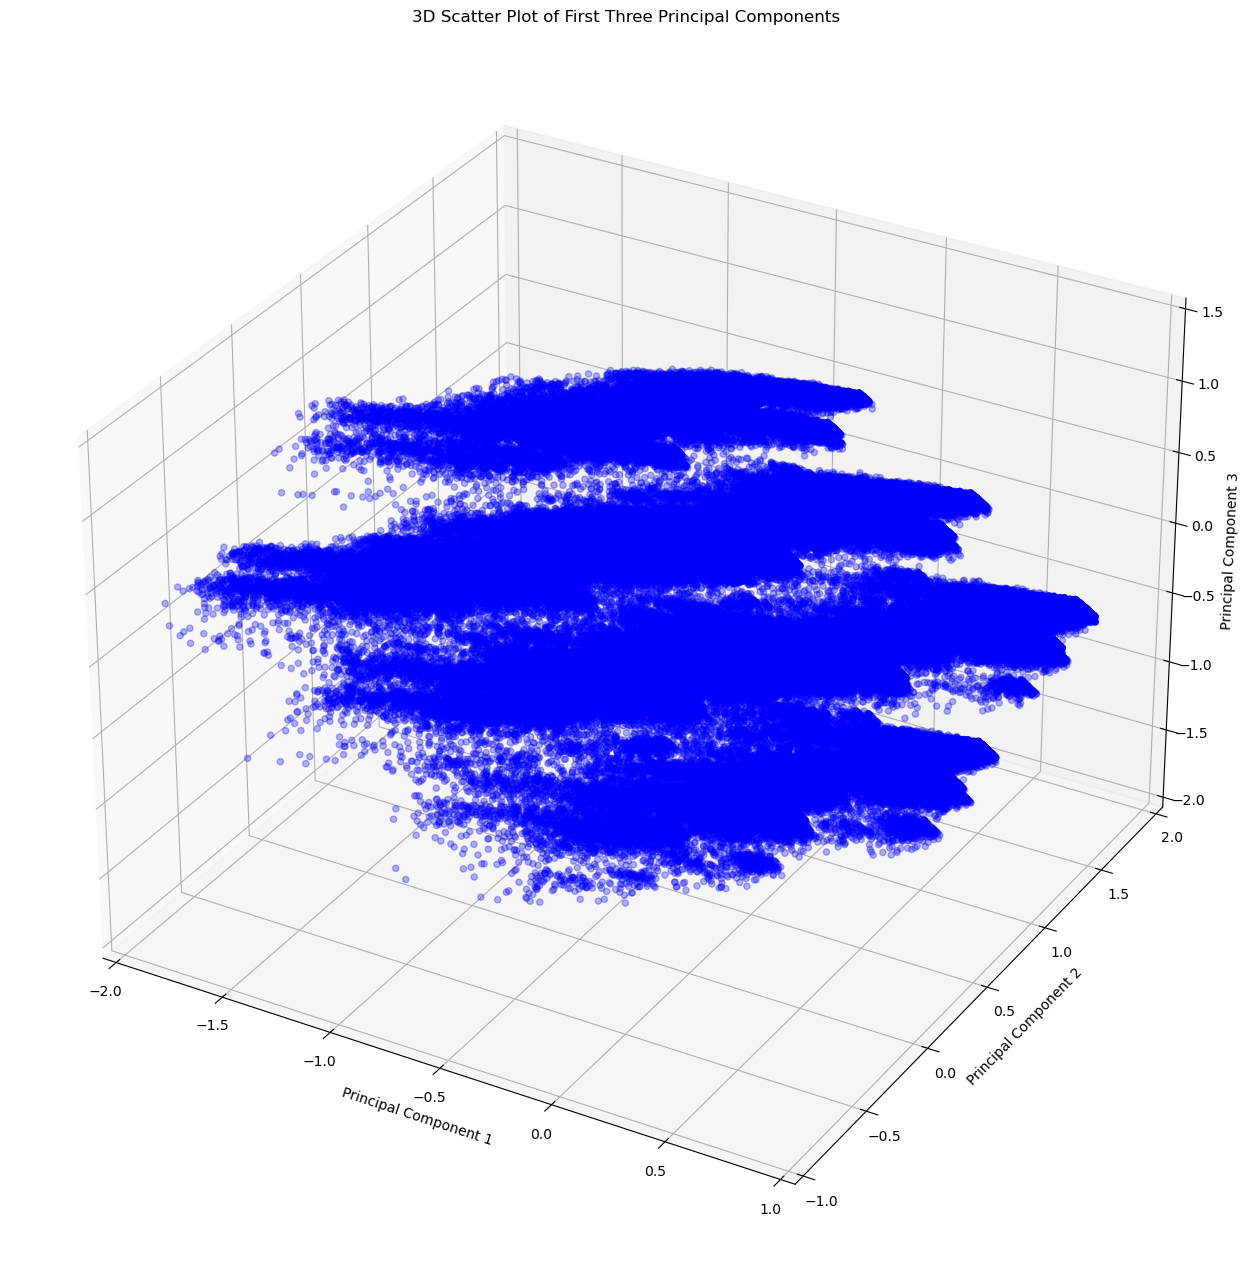

In [ ]:
pca = PCA(k=3, inputCol="features", outputCol="pca_features")  # Only get 3 components
pca_model = pca.fit(X_vector)

# Transform the dataset with the PCA model
X_pca_new = pca_model.transform(X_vector)
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')
pca_features = np.array(X_pca_new.select("pca_features").rdd.map(lambda row: row[0].toArray()).collect())

# Scatter plot of the first three principal components
ax.scatter(pca_features[:, 0], pca_features[:, 1], pca_features[:, 2], c='b', marker='o', alpha=0.3)
ax.set_xlim(-2, 1)  # Adjust these values based on your PCA results
ax.set_ylim(-1, 2)  # Adjust these values based on your PCA results
ax.set_zlim(-2, 1.5)
# Set labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Scatter Plot of First Three Principal Components')

# Show the plot
plt.show()


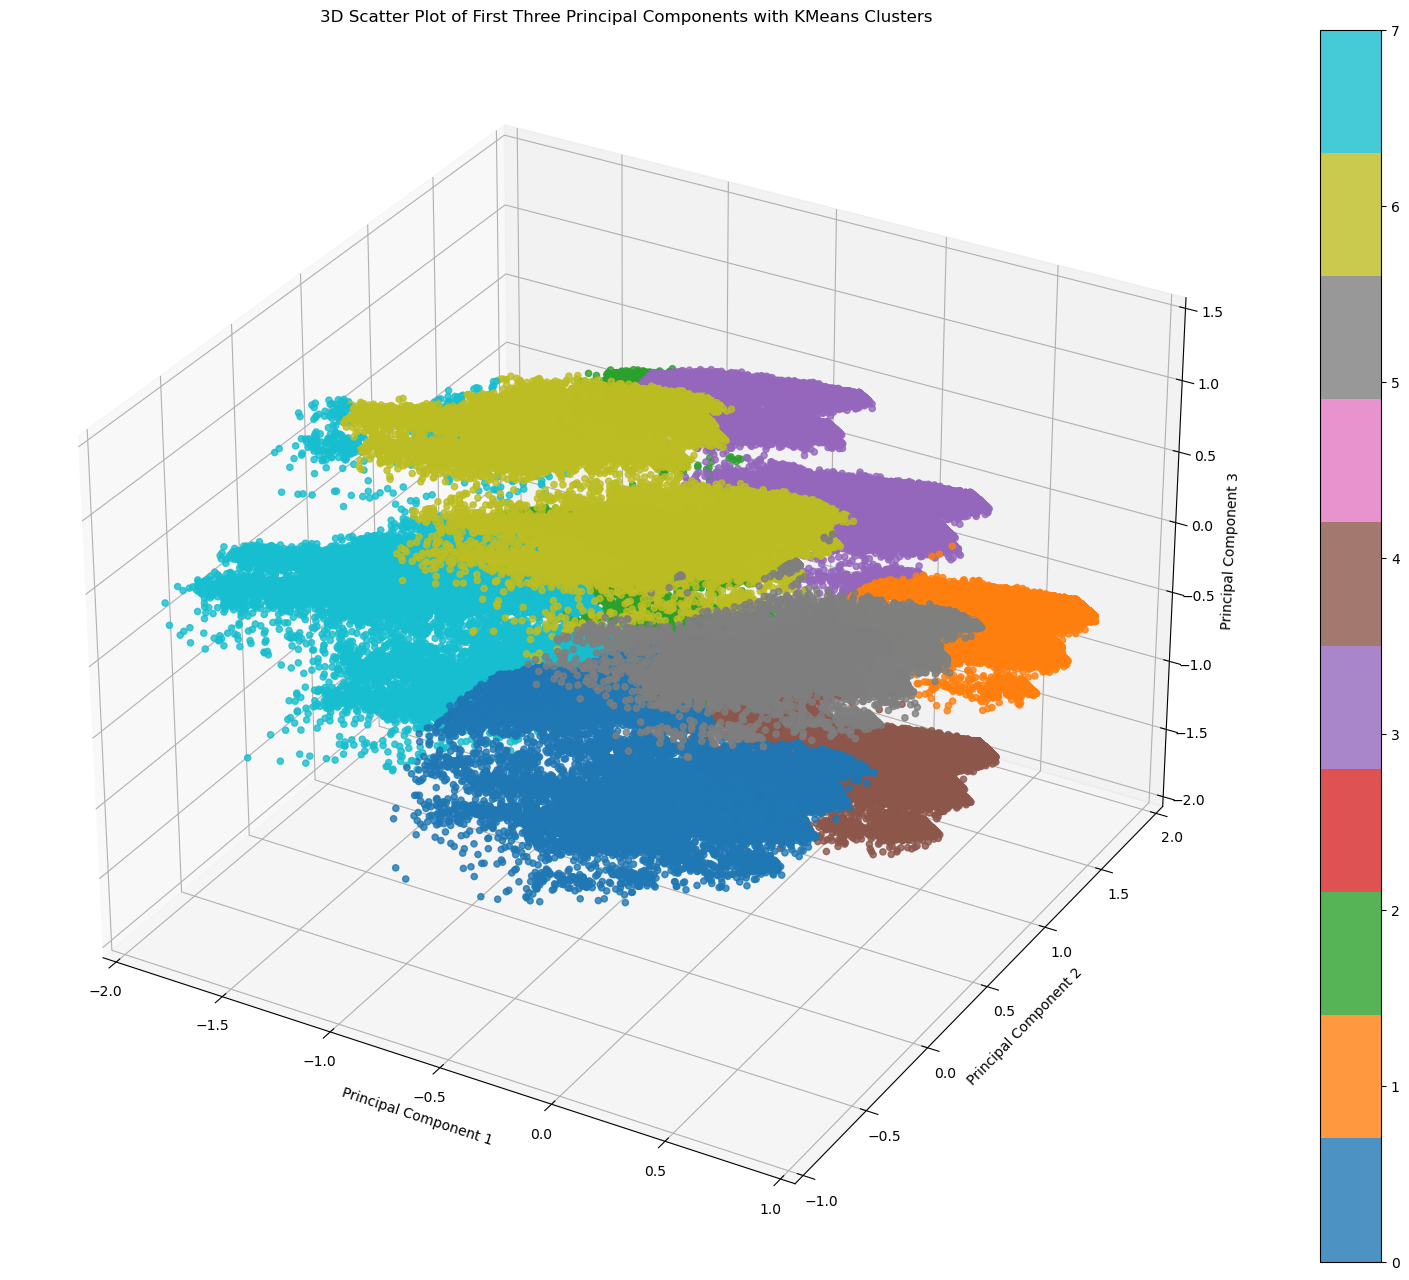

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8)  # Set number of clusters
clusters = kmeans.fit_predict(pca_features)

# Step 3: Plot the PCA-transformed data with cluster colors
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

# Use clusters to color the scatter plot
scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], pca_features[:, 2], 
                     c=clusters, cmap='tab10', marker='o', alpha=0.8)

# Set axis limits (adjust based on your data)
ax.set_xlim(-2, 1)
ax.set_ylim(-1, 2)
ax.set_zlim(-2, 1.5)

# Set labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Scatter Plot of First Three Principal Components with KMeans Clusters')

# Add color bar to indicate different clusters
plt.colorbar(scatter)

# Show the plot
plt.show()

#### 4.2. Factor Analysis

In [ ]:
from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity

In [ ]:
X_pd = X_pyspark.toPandas()
chi_square_value, p_value = calculate_bartlett_sphericity(X_pd)
print(f"Bartlett's Test: Chi-square = {chi_square_value:.4f}, p-value = {p_value:.4f}")

Bartlett's Test: Chi-square = nan, p-value = nan


In [ ]:
_,kmo_model=calculate_kmo(X_pd)
print(f'The Kaiser-Meyer-Olkin (KMO) measure is {kmo_model}.')

The Kaiser-Meyer-Olkin (KMO) measure is 0.6820631136990494.


It is an acceptable value and the dataset is suitable for a factor analysis.

In [ ]:
fa = FactorAnalyzer(n_factors=15)
fa.fit(X_pd)

FactorAnalyzer(n_factors=15, rotation_kwargs={})

In [ ]:
import pyspark.pandas as ps
loadings = fa.loadings_  # The factor loadings matrix from factor analysis
variable_names = X_pd.columns  # The names of the variables used in the analysis

# Create a DataFrame for better handling of the loadings matrix
loadings_df = ps.DataFrame(
    loadings, 
    columns=[f'Factor {i+1}' for i in range(loadings.shape[1])],  # Naming the factors
    index=variable_names  # Setting the index to the variable names
)
loadings_df.head(25)

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15
HighBP,-0.028598,-0.000132,-0.020294,-0.005275,-0.179740,1.046614,-0.004794,-0.002603,0.007129,-0.016349,0.085385,0.044153,-0.037752,0.047603,0.007677
HighChol,-0.021154,-0.001969,-0.007565,-0.012882,1.098016,-0.188503,-0.001301,-0.000634,0.002874,-0.017571,0.021036,-0.004701,-0.014860,0.025172,0.020248
CholCheck,0.071457,-0.008370,0.011048,0.017751,0.017919,0.020988,-0.001056,-0.003261,-0.005906,0.036054,0.073494,0.039489,0.020856,-0.038156,-0.032033
BMI,-0.014951,0.005950,0.024213,-0.083490,0.002313,0.028247,0.017742,0.004938,-0.003716,0.014069,-0.199751,0.704936,0.000812,0.012410,0.044623
Smoker,0.003540,1.043111,0.003922,-0.006412,-0.002712,-0.002079,0.001502,-0.001366,-0.195949,0.008774,0.038049,0.009625,0.000757,0.002133,-0.004347
Stroke,0.003611,-0.004615,-0.005638,0.009377,-0.008886,0.010628,-0.011490,-0.008327,0.000819,-0.003118,-0.003742,-0.025111,0.345087,-0.018979,0.044754
HeartDiseaseorAttack,-0.027472,0.008611,-0.009477,-0.027920,-0.003569,-0.046466,0.011485,0.007013,0.005109,0.009388,0.052664,0.038134,0.599424,0.067858,-0.043453
PhysActivity,0.030307,-0.011990,0.066536,-0.168162,0.017780,0.041929,0.043948,0.004377,-0.011892,0.108492,-0.105523,-0.127139,0.046316,0.020291,-0.055488
Fruits,-0.017205,0.005822,1.119108,0.019790,-0.008605,-0.017036,-0.224111,-0.000667,0.005272,-0.029483,0.018536,0.026884,-0.018159,0.006123,0.019153
Veggies,-0.001955,0.002329,-0.119749,0.025784,-0.001548,-0.003983,1.074360,-0.001252,0.001784,-0.019273,0.018522,0.026241,-0.004524,-0.018589,0.016030


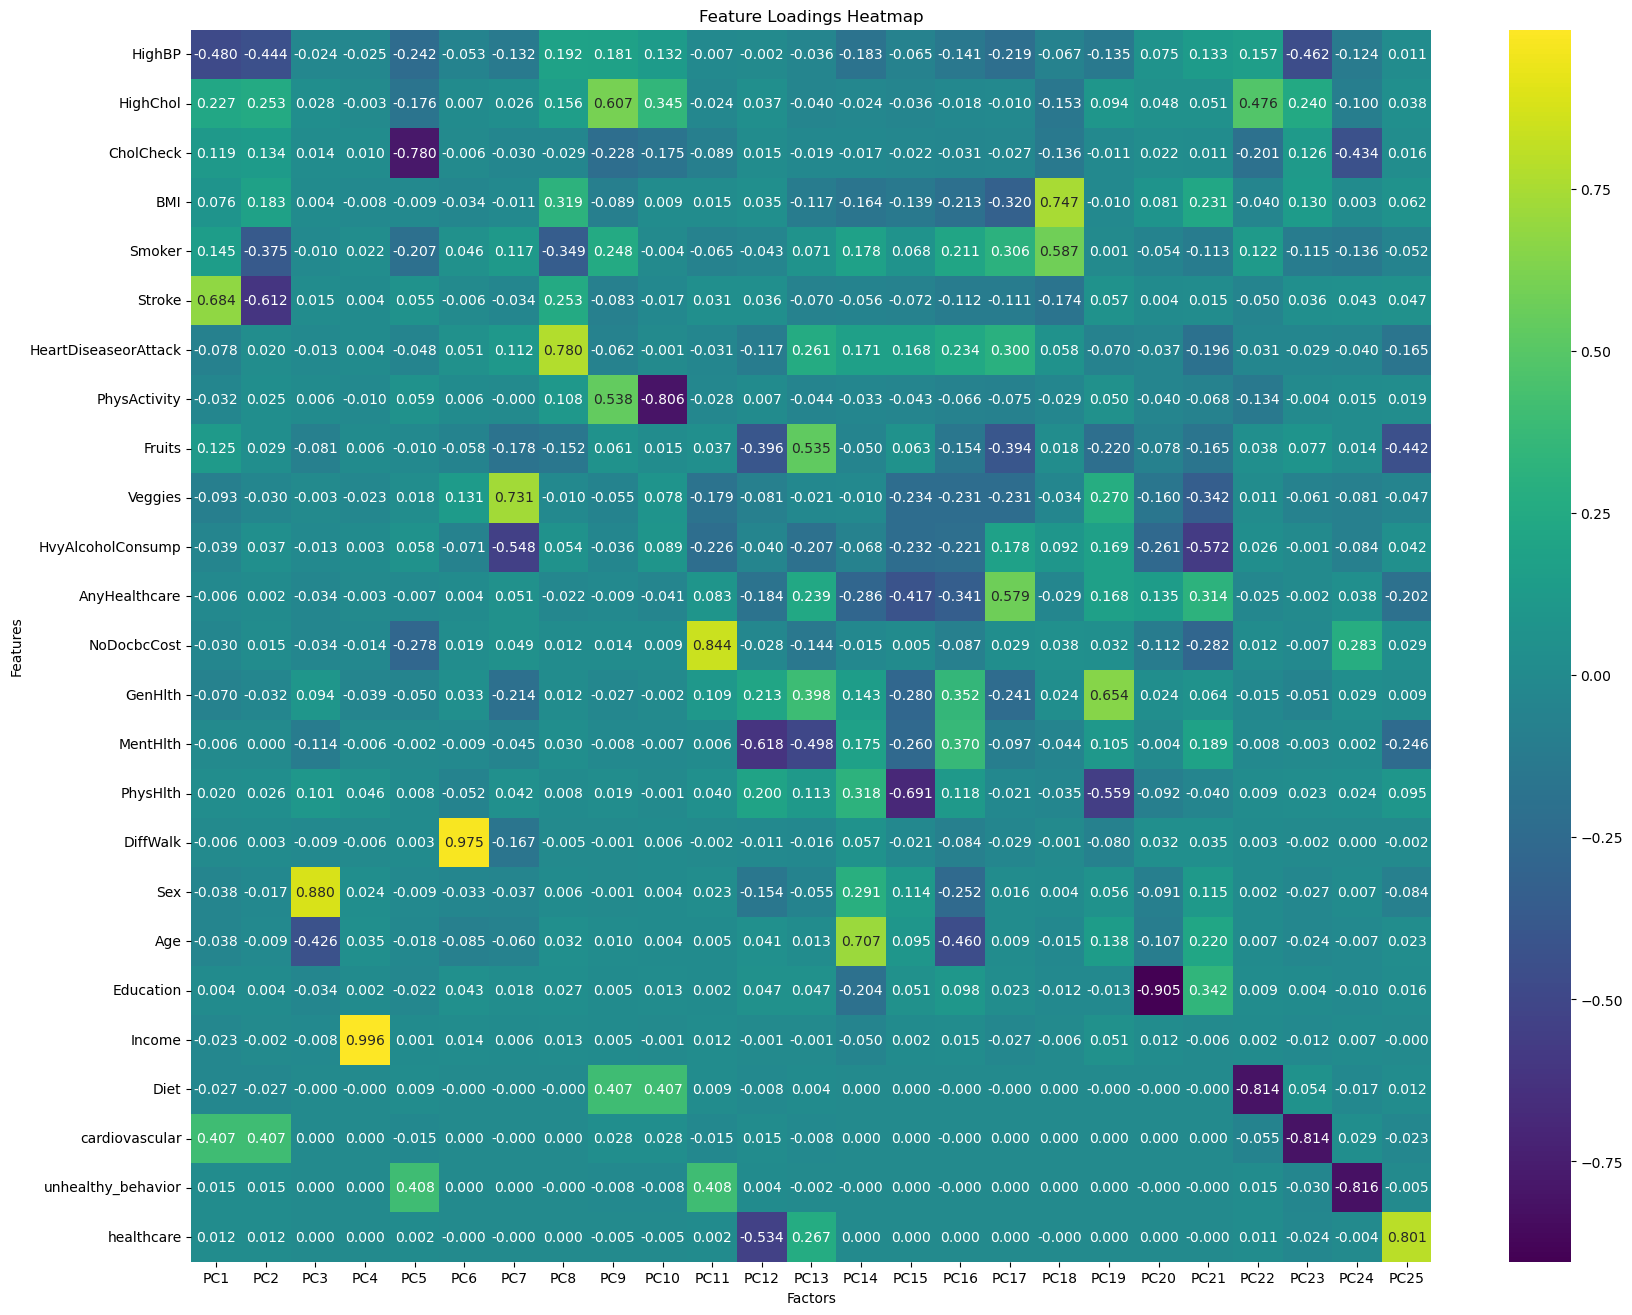

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'feature_loadings_df' is already created and rounded as per your earlier steps
# feature_loadings_df = feature_loadings_df.round(3)

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Create a heatmap with seaborn
sns.heatmap(feature_loadings_df, annot=True, cmap='viridis', fmt='.3f', cbar=True)

# Add labels and title
plt.title("Feature Loadings Heatmap")
plt.xlabel("Factors")
plt.ylabel("Features")

# Show the plot
plt.show()


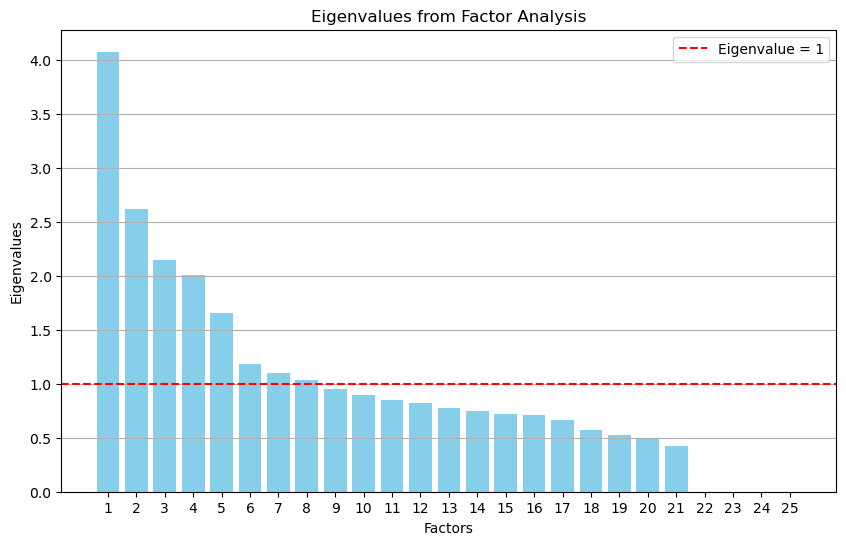

In [ ]:
ev, v = fa.get_eigenvalues()

# Step 4: Plot Eigenvalues with Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(ev) + 1), ev, color='skyblue')
plt.title('Eigenvalues from Factor Analysis')
plt.xlabel('Factors')
plt.ylabel('Eigenvalues')
plt.xticks(range(1, len(ev) + 1))  # Set x-ticks to factor numbers
plt.axhline(y=1, color='r', linestyle='--', label='Eigenvalue = 1')
plt.legend()
plt.grid(axis='y')
plt.show()

In [ ]:
X_fa = spark.createDataFrame(fa.transform(X_pd), [f'Factor{i}' for i in range(1,16)])
X_fa.show(truncate=False)

+-------------------+---------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------+
|Factor1            |Factor2              |Factor3            |Factor4             |Factor5            |Factor6             |Factor7            |Factor8             |Factor9             |Factor10            |Factor11            |Factor12             |Factor13            |Factor14            |Factor15             |
+-------------------+---------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------+
|0.3674760327382718 |1.026279974795931    |-1.274234

## **5.Machine Learning Algorithms**

In [18]:
# Split the data into train and test sets
train_data, test_data = data_pyspark.randomSplit([0.8, 0.2], seed=1234)

In [ ]:
# Assemble the features
assembler = VectorAssembler(inputCols=X_pyspark.columns, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

In [ ]:
# Logistic Regression
lr = LogisticRegression(labelCol="Diabetes_binary", featuresCol="features")

# Param grid for hyperparameter tuning
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Cross-validation
cv_lr = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid_lr,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

# Fit model
lr_model = cv_lr.fit(train_data)


In [ ]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="Diabetes_binary", featuresCol="features")

paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 20]) \
    .addGrid(dt.maxBins, [32, 64]) \
    .build()

cv_dt = CrossValidator(estimator=dt,
                    estimatorParamMaps=paramGrid_dt,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

dt_model = cv_dt.fit(train_data)


In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(labelCol="Diabetes_binary", featuresCol="features")

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

cv_rf = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid_rf,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

rf_model = cv_rf.fit(train_data)


In [ ]:
# Gradient-Boosted Tree Classifier
gbt = GBTClassifier(labelCol="Diabetes_binary", featuresCol="features", maxIter=100)

paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 20]) \
    .build()

cv_gbt = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid_gbt,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

gbt_model = cv_gbt.fit(train_data)


In [ ]:
# Support Vector Machine
svm = LinearSVC(labelCol="Diabetes_binary", featuresCol="features")

paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1, 1.0]) \
    .build()

cv = CrossValidator(estimator=svm,
                    estimatorParamMaps=paramGrid,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

svm_model = cv.fit(train_data)


In [ ]:
# Naive Bayes Classifier
nb = NaiveBayes(labelCol="Diabetes_binary", featuresCol="features")

paramGrid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1.0, 1.5]) \
    .build()

cv_nb = CrossValidator(estimator=nb,
                    estimatorParamMaps=paramGrid_nb,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

nb_model = cv_nb.fit(train_data)


In [ ]:
# MLP classifier
mlp = MultilayerPerceptronClassifier(labelCol="Diabetes_binary", featuresCol="features", layers=layers, seed=1234)

paramGrid_mlp = ParamGridBuilder() \
    .addGrid(mlp.layers, [[len(X_pyspark.columns), 5, 4, 2], [len(X_pyspark.columns), 10, 5, 2]]) \
    .build()

cv_mlp = CrossValidator(estimator=mlp,
                    estimatorParamMaps=paramGrid_mlp,
                    evaluator=BinaryClassificationEvaluator(labelCol="Diabetes_binary"),
                    numFolds=5)

mlp_model = cv_mlp.fit(train_data)